## 0. Setup packages and Constants

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import numpy as np
import sys
from tqdm import tqdm

# Utils
from utils import plotters

plt.style.use('./utils/style.mplstyle')

%load_ext autoreload
%autoreload 2

In [2]:
#Path to the ROOT file containing the universe covariance matrices
DATA_PATH = '/exp/sbnd/data/users/brindenc/xsec_analysis/test/sbruce/uni_med_weight4.root'

#Bin indices for the covariance matrix
P_BINS = np.arange(0, 10)
COSTHETA_OVERFLOW_BINS = np.arange(10, 20)
COSTHETA_BINS = np.arange(10,19)
CAT_BINS = np.arange(0,6)
len(CAT_BINS)

6

# 1. Load the data

In [3]:
tree = uproot.open(DATA_PATH)
keys = tree.keys()
#tree.keys() #display all keys in the ROOT file

In [4]:
len(keys)

568930

In [5]:
key = 'SBND_CC1muX_1D/+exp+sbnd+data+users+brindenc+xsec_analysis+test+sbruce+cc1mux_med_weight_copy.root/unweighted_0_reco;1'
tree[key].to_hist()

Hist(Regular(19, 0, 19, name='xaxis', label=' reco bin number'), storage=Weight()) # Sum: WeightedSum(value=250, variance=250)

In [6]:
p_nan_keys = []
costheta_nan_keys = []
wrong_length_keys = []
dir_keys = []
non_hist_keys = []
accepted_keys = []
negative_keys = []
zero_keys = []
class_names = []

twod_nan_keys = []
twod_non_square_keys = []
twod_valid_keys = []


#Check for nan values in the universes
for i,_key in tqdm(enumerate(keys)):
  is_valid = True
  # if i > 100000:
  #   break
  #print(i,_key)
  _tree = tree[_key]
  #skip directories
  if '.root/' not in _key: 
    dir_keys.append(_key)
    continue
  
  #skip non-histograms
  if _tree.classname == 'TH1D':
  
    #Check if the histogram has the correct number of bins
    if (len(_tree.to_numpy()[0]) != (len(P_BINS) + len(COSTHETA_BINS))) \
      and (len(_tree.to_numpy()[0]) != (len(P_BINS) + len(COSTHETA_OVERFLOW_BINS))): #account for overflow bin 
      
      #print(f'Incorrect number of bins for {_key}')
      wrong_length_keys.append(_key)
      is_valid=False
    #Which keys do we use depends on which length it matches
    if len(_tree.to_numpy()[0]) == (len(P_BINS) + len(COSTHETA_BINS)):
      costheta_bins = COSTHETA_BINS
    elif len(_tree.to_numpy()[0]) == (len(P_BINS) + len(COSTHETA_OVERFLOW_BINS)):
      costheta_bins = COSTHETA_OVERFLOW_BINS
    
    #Get universe values for the momentum histogram
    p_vals = _tree.to_numpy()[0][P_BINS]
    if np.isnan(p_vals).sum() > 0:
      p_nan_keys.append(_key)
      break
    
    #Get universe values for the costheta histogram
    costheta_vals = _tree.to_numpy()[0][costheta_bins]
    if np.isnan(costheta_vals).sum() > 0:
      costheta_nan_keys.append(_key)
      break
      
    #Check for negative values
    if (p_vals < 0).sum() > 0:
      negative_keys.append(_key)
      break
    if (costheta_vals < 0).sum() > 0:
      negative_keys.append(_key)
      break
    
    #Check for zero values
    if (p_vals == 0).sum() > 0:
      zero_keys.append(_key)
    if (costheta_vals == 0).sum() > 0:
      zero_keys.append(_key)
    if is_valid:
      accepted_keys.append(_key)
  elif _tree.classname == 'TH2D':
    #print(_tree.to_numpy()[0].shape)
    #Get number of bins, which should match either len(P_BINS) + len(COSTHETA_OVERFLOW_BINS) or len(P_BINS) + len(COSTHETA_BINS)
    nxbins = _tree.to_numpy()[0].shape[0] 
    nybins = _tree.to_numpy()[0].shape[1]
    if nxbins != nybins:
      #print(f'array shape: {_tree.to_numpy()[0].shape} for {_key}')
      #raise ValueError('Histogram is not square')
      twod_non_square_keys.append(_key)
    #continue
    if ((nxbins != (len(P_BINS) + len(COSTHETA_BINS)))\
      and (nxbins != (len(COSTHETA_OVERFLOW_BINS) + len(P_BINS)))\
      and (nxbins != len(CAT_BINS))):
      print(f'Incorrect number of x bins for {_key}: {nxbins}')
      wrong_length_keys.append(_key)
      break
    if ((nybins != (len(P_BINS) + len(COSTHETA_BINS)))\
      and (nybins != (len(COSTHETA_OVERFLOW_BINS) + len(P_BINS)))\
      and (nybins != len(CAT_BINS))):
      print(f'Incorrect number of y bins for {_key}: {nybins}')
      wrong_length_keys.append(_key)
      break

    # Convert to numpy array for processing (assumes appropriate method exists)
    vals = _tree.to_numpy()[0] # 2d array

    # Check for NaN values
    if np.isnan(vals).sum() > 0:
      twod_nan_keys.append(_key)
      break

    # Check for negative values
    if (vals < 0).sum() > 0:
      negative_keys.append(_key)
      break

    # Check for zero values
    if (vals == 0).sum() > 0:
      zero_keys.append(_key)
    if is_valid:
      twod_valid_keys.append(_key)
  else:
    non_hist_keys.append(_key)

0it [00:00, ?it/s]

568930it [12:51, 737.80it/s]


In [7]:
print(f'len of p_nan_keys: {len(p_nan_keys)}\n',
  f'len of costheta_nan_keys: {len(costheta_nan_keys)}\n',
  f'len of wrong_length_keys: {len(wrong_length_keys)}\n',
  f'len of dir_keys: {len(dir_keys)}\n',
  f'len of non_hist_keys: {len(non_hist_keys)}\n',
  f'len of accepted_keys: {len(accepted_keys)}\n',
  f'len of negative_keys: {len(negative_keys)}\n',
  f'len of zero_keys: {len(zero_keys)}\n',
  f'len of class_names: {len(class_names)}\n',
  f'len of twod_nan_keys: {len(twod_nan_keys)}\n',
  f'len of twod_non_square_keys: {len(twod_non_square_keys)}\n',
  f'len of twod_valid_keys: {len(twod_valid_keys)}')

len of p_nan_keys: 0
 len of costheta_nan_keys: 0
 len of wrong_length_keys: 0
 len of dir_keys: 94840
 len of non_hist_keys: 0
 len of accepted_keys: 158030
 len of negative_keys: 0
 len of zero_keys: 316060
 len of class_names: 0
 len of twod_nan_keys: 0
 len of twod_non_square_keys: 158030
 len of twod_valid_keys: 316060


In [58]:
key = twod_non_square_keys[-2]
tree[key].to_hist()

Hist(
  Regular(20, 0, 20, name='xaxis', label=' true bin number'),
  Regular(19, 0, 19, name='yaxis', label=' reco bin number'),
  storage=Weight()) # Sum: WeightedSum(value=472, variance=472)

In [29]:
key = twod_non_square_keys[0]
tree[key].to_numpy()[0].shape

(20, 19)

In [59]:
key = accepted_keys[0]
tree[key].to_hist()

Hist(Regular(19, 0, 19, name='xaxis', label=' reco bin number'), storage=Weight()) # Sum: WeightedSum(value=250, variance=250)

In [60]:
key = accepted_keys[1]
tree[key].to_hist()

Hist(Regular(20, 0, 20, name='xaxis', label=' true bin number'), storage=Weight()) # Sum: WeightedSum(value=3664, variance=3664)

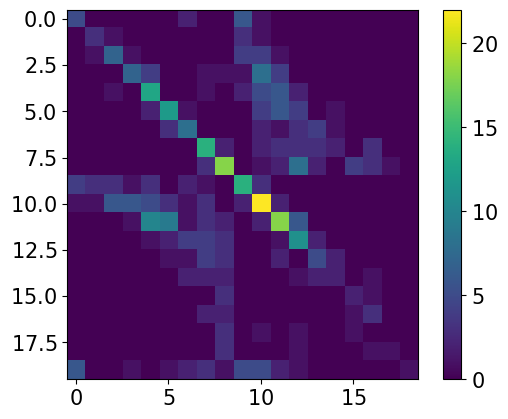

In [31]:
plt.imshow(tree[key].to_numpy()[0])
plt.colorbar()

In [16]:
_key

'SBND_CC1muX_1D/+exp+sbnd+data+users+brindenc+xsec_analysis+test+sbruce+cc1mux_med_weight.root/weight_GENIEReWeight_SBN_v1_multisim_COHVariationResponse_64_true2d;1'

In [17]:
len(tree['SBND_CC1muX_1D/+exp+sbnd+data+users+brindenc+xsec_analysis+test+sbruce+cc1mux_med_weight.root/unweighted_0_reco;1'].to_numpy()[0]),\
len(tree['SBND_CC1muX_1D/+exp+sbnd+data+users+brindenc+xsec_analysis+test+sbruce+cc1mux_med_weight.root/unweighted_0_reco;1'].to_numpy()[1])

(19, 20)

In [7]:
len(wrong_length_keys),len(dir_keys),len(non_hist_keys),len(p_nan_keys),len(costheta_nan_keys),len(accepted_keys),len(negative_keys),len(zero_keys)

(0, 6, 663, 0, 0, 332, 0, 0)

In [81]:
wrong_length_th1d = tree[wrong_length_keys[0]].to_numpy()
correct_length_th1d = tree[accepted_keys[0]].to_numpy()
len(wrong_length_th1d[0]), len(P_BINS) + len(COSTHETA_BINS), len(correct_length_th1d[0])

IndexError: list index out of range

In [68]:
correct_length_th1d[0],accepted_keys[0]

(array([11.,  4.,  9.,  9., 19., 16., 13., 22., 22., 21., 33., 25., 21.,
         9.,  4.,  4.,  6.,  1.]),
 'SBND_CC1muX_1D/+exp+sbnd+data+users+brindenc+xsec_analysis+test+sbruce+cc1mux_med_weight.root/unweighted_0_reco;1')

In [69]:
len(wrong_length_th1d[1]),len(tree[key].to_numpy()[1])

(19, 19)

(array([1., 3., 1., 0., 3., 1., 1., 0., 1., 0., 1., 4., 0., 1., 0., 0., 0.,
        1.]),
 array([ 1.        ,  2.77777778,  4.55555556,  6.33333333,  8.11111111,
         9.88888889, 11.66666667, 13.44444444, 15.22222222, 17.        ,
        18.77777778, 20.55555556, 22.33333333, 24.11111111, 25.88888889,
        27.66666667, 29.44444444, 31.22222222, 33.        ]),
 <BarContainer object of 18 artists>)

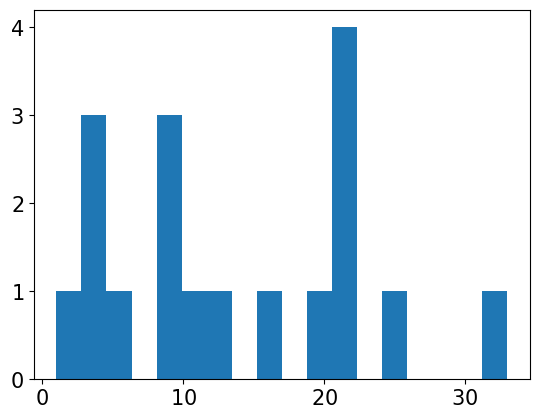

In [23]:
P_BINS,COSTHETA_BINS

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]))

In [29]:
_tree.classnames()
tree[key].classnames()

AttributeError: 'Model_TH1D_v2' object has no attribute 'classnames'